In [39]:
import numpy as np
import sys
import os
import torch
import wandb

import itertools

# Define the path to the parent project folder
project_path = r'C:/Users/palig/MSE/Vertiefungsprojekt1/mse_vp1_rulestimation'

# Add the path to sys.path if it does not already exist
if project_path not in sys.path:
    sys.path.append(project_path)

from torch import optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt

from models.att import ATTModel
from utils.preprocess import CMAPSS_Dataset
from utils.train import Trainer


# Configure device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# normalization

data_path = os.path.join(project_path, 'data', 'final')
save_path = os.path.join(project_path, 'models', 'trained_models')
model_path = os.path.join(project_path, 'models')
result_path = os.path.join(project_path, 'data', 'results')

model_results = {}

In [40]:
api = wandb.Api()

project_name = "mse-vp1"
entity = "p-alig-fh-ost"

In [41]:
subset = '13'
max_rul = 125
seq_length = 30

config={
    "learning_rate": 0.001,
    "epochs": 400,
    "model": f"ATT_{subset}"
    }

Training of group 1 (DF1 and DF3)

In [4]:
trainset = CMAPSS_Dataset(
    mode = 'train',
    data_path=data_path,
    subset=subset,
    seq_length=seq_length,
    max_rul=max_rul
)

train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size

train_subset, val_subset = random_split(trainset, [train_size, val_size])

train_loader = DataLoader(dataset=train_subset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset=val_subset, batch_size=64, shuffle=False, num_workers=0)

# Training
global_step = 0
iterations = 1
best_score_list = []
best_RMSE_list = []
for iteration in range(iterations):
    run = wandb.init(
        project=project_name,
        name=f"ATT_{subset}",
        config=config,
        reinit=True   # Wichtig! Startet WandB für jede Iteration neu
    )
    model = ATTModel()
    print('Model loaded')
    optimizer = optim.Adam(model.parameters(), lr=run.config["learning_rate"])
    epochs = run.config["epochs"]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    trainer = Trainer(model=model,
                        model_optimizer=optimizer,
                        print_every=50,
                        epochs=epochs,
                        device=device,
                        prefix=subset,
                        handcrafted=True
                        )
    best_score, best_RMSE, global_step = trainer.train(train_loader, val_loader, iteration, global_step)
    best_score_list.append(best_score)
    best_RMSE_list.append(best_RMSE)
    if iteration == np.argmin(best_RMSE_list):
        torch.save(model.state_dict(), os.path.join(save_path, f'{run.config["model"]}_best.pth'))
        print(f"Best model saved at iteration {iteration + 1}.")

    run.finish()

best_score_list = np.array(best_score_list)
best_RMSE_list = np.array(best_RMSE_list)

result = np.concatenate((best_score_list, best_RMSE_list)).reshape(2, iterations)
print(result)


Found 200 unique motor IDs in the data set.


wandb: Currently logged in as: p-alig (p-alig-fh-ost). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Model loaded
cuda
Epoch: 1
test result: score: 0.7742257976091973, RMSE: 0.17065152946348036
Epoch: 2
test result: score: 0.6828914073064797, RMSE: 0.15468999827912472
best_score_checkpoints saved successfully at ./checkpoints/ATT_13/13_iteration1_best_score.pth.tar!
best_RMSE_checkpoints saved successfully at ./checkpoints/ATT_13/13_iteration1_best_RMSE.pth.tar!
Epoch: 3
test result: score: 0.773563592718127, RMSE: 0.17813095559952544
Epoch: 4
test result: score: 0.7211117284093912, RMSE: 0.16908320345732847
Epoch: 5
test result: score: 0.66604672105435, RMSE: 0.15926289627746143
best_score_checkpoints saved successfully at ./checkpoints/ATT_13/13_iteration1_best_score.pth.tar!
Epoch: 6
test result: score: 0.668813684317876, RMSE: 0.15826099885602396
Epoch: 7
test result: score: 0.7064937652249867, RMSE: 0.17007213012857084
Epoch: 8
test result: score: 0.6602229165181004, RMSE: 0.15223818128421326
best_score_checkpoints saved successfully at ./checkpoints/ATT_13/13_iteration1_best_sco

epoch/epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇██
epoch/train-RMSE,██▇▇▆▅▅▅▅▅▅▅▅▅▄▃▃▃▃▃▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/train-loss,█▇▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/val-RMSE,██▇▅▇▆▅▆▅▅▅▅▄▆▅▄▃▃▄▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/val-loss,▇█▅▄▅▄▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/val-score,█▆▆▅▅▄▄▄▄▄▃▃▃▃▃▂▂▃▂▂▂▂▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁
train/RMSE,█▅▃▅▄▄▃▃▅▄▃▂▃▂▃▂▂▃▄▃▄▂▂▂▂▂▂▁▂▂▃▃▂▂▂▃▁▂▃▁
train/loss,█▃▄▄▃▃▆▃▃▂▃▃▃▃▃▂▂▂▂▃▂▅▂▂▂▁▂▂▁▁▂▃▁▁▂▁▂▂▁▃
validation/RMSE,██▆▆▅▆▄▅▄▄▃▄▃▂▃▂▂▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁
validation/RMSE_rul,██▆▇▅▅▄▄▄▄▄▄▃▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
validation/loss,█▆▅▆▅▃▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


[[0.26166736]
 [0.05687745]]


✔️ Last completed run: nbkcj3ab


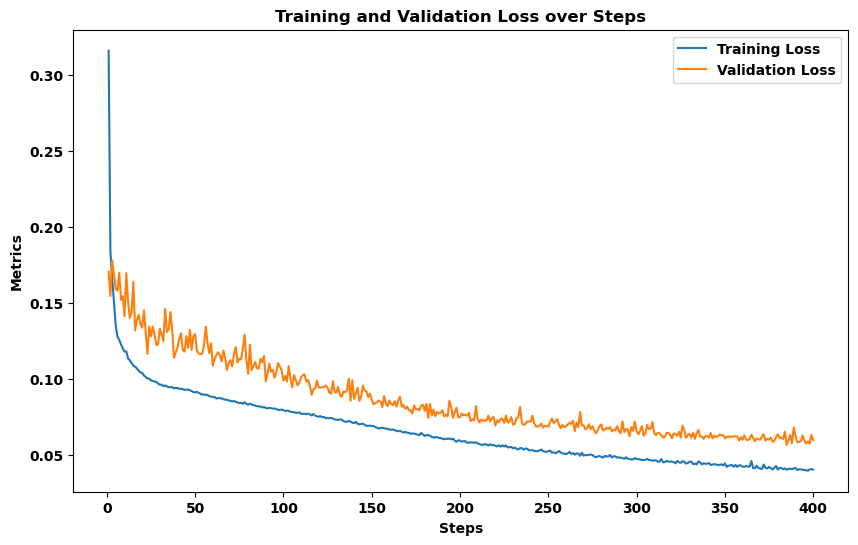

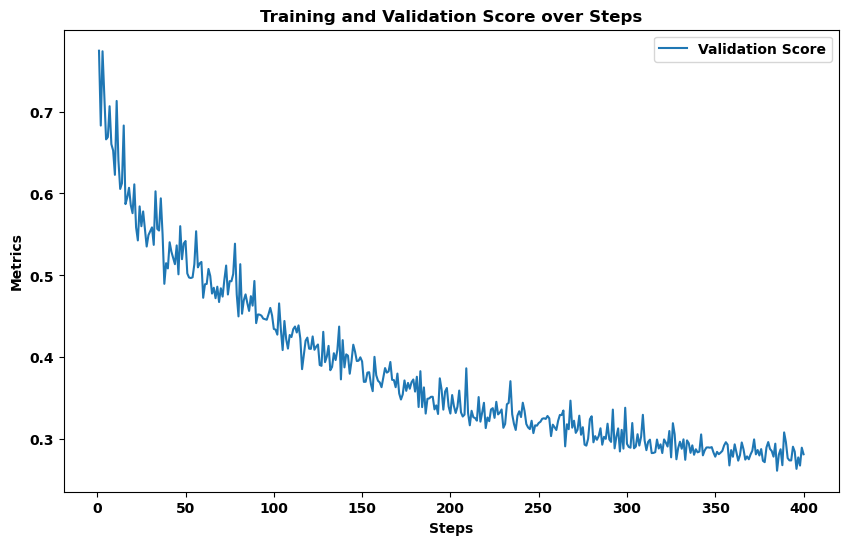

In [5]:
api = wandb.Api()

# Retrieve all runs
runs = api.runs(f"{entity}/{project_name}")

# Sort by end time (stop time) and filter only completed runs
finished_runs = [run for run in runs if run.state == "finished"]

if not finished_runs:
    print("❌ No completed run found!")
else:
    last_run = sorted(finished_runs, key=lambda r: r.created_at, reverse=True)[0]
    print("✔️ Last completed run:", last_run.id)

    run = api.run(f"{entity}/{project_name}/{last_run.id}")

history = run.history()

train_rmse = history["epoch/train-RMSE"]
val_rmse = history["epoch/val-RMSE"]
val_score = history["epoch/val-score"]

steps = range(len(history["_step"].values))

plt.figure(figsize=(10, 6))
plt.plot(steps, train_rmse, label="Training Loss")
plt.plot(steps, val_rmse, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Metrics")
plt.title("Training and Validation Loss over Steps")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(steps, val_score, label="Validation Score")
plt.xlabel("Steps")
plt.ylabel("Metrics")
plt.title("Training and Validation Score over Steps")
plt.legend()
plt.show()

Prediction of group 1 (DF1 and DF3)

In [42]:
from sklearn.metrics import mean_squared_error

# Modell initialisieren und gespeicherte Gewichte laden
model = ATTModel()
model.load_state_dict(torch.load(os.path.join(save_path, f'{config["model"]}_best.pth')))
model = model.to(device)
model.eval()  # Modell in den Evaluierungsmodus setzen

testset = CMAPSS_Dataset(
    mode = 'test',
    data_path=data_path,
    subset=subset,
    seq_length=seq_length,
    max_rul=max_rul,
    handcrafted=True
)
test_loader = DataLoader(dataset=testset, batch_size=1000, shuffle=False, num_workers=0)

all_predictions_13 = []
all_labels_13 = []

# Testdaten auswerten
with torch.no_grad():
    for data in test_loader:
        X, handcrafted_feature, y = data
        X, handcrafted_feature, y = X.to(device), handcrafted_feature.to(device), y.to(device)

        predictions = model(X, handcrafted_feature)

        # Verarbeite die Vorhersagen (z. B. Speichern oder Auswerten)
        pred_batch = predictions.squeeze().detach().cpu().numpy() * max_rul
        labels_batch = y.squeeze().detach().cpu().numpy() * max_rul

        # Sammle alle Vorhersagen und Labels
        all_predictions_13.extend(pred_batch)
        all_labels_13.extend(labels_batch)

# Konvertiere die Listen in NumPy-Arrays
all_predictions_13 = np.array(all_predictions_13)
all_labels_13 = np.array(all_labels_13)

rmse_13 = np.sqrt(mean_squared_error(all_labels_13, all_predictions_13))
print(f'RMSE: {rmse_13:.3f}')

score_13 = Trainer.score(torch.tensor(all_labels_13), torch.tensor(all_predictions_13))
print(f'Score: {score_13:.3f}')

# Save predictions
model_results["ATT_13"] = {
    "predictions": all_predictions_13,
    "labels": all_labels_13,
    "rmse": rmse_13,
    "score": score_13
}

Found 200 unique motor IDs in the data set.
(200, 34)
RMSE: 14.285
Score: 751.669


Training of group 2 (DF2 and DF4)

In [43]:
subset = '24'
max_rul = 125
seq_length = 30

config={
    "learning_rate": 0.001,
    "epochs": 400,
    "model": f"ATT_{subset}"
    }

In [8]:

trainset = CMAPSS_Dataset(
    mode = 'train',
    data_path=data_path,
    subset=subset,
    seq_length=seq_length,
    max_rul=max_rul
)

train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size

train_subset, val_subset = random_split(trainset, [train_size, val_size])

train_loader = DataLoader(dataset=train_subset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset=val_subset, batch_size=64, shuffle=False, num_workers=0)

# Training
global_step = 0
iterations = 1
best_score_list = []
best_RMSE_list = []
for iteration in range(iterations):
    run = wandb.init(
        project=project_name,
        name=f"ATT_{subset}",
        config=config,
        reinit=True   # Wichtig! Startet WandB für jede Iteration neu
    )
    model = ATTModel()
    print('Model loaded')
    optimizer = optim.Adam(model.parameters(), lr=run.config["learning_rate"])
    epochs = run.config["epochs"]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    trainer = Trainer(model=model,
                        model_optimizer=optimizer,
                        print_every=50,
                        epochs=epochs,
                        device=device,
                        prefix=subset,
                        handcrafted=True
                        )
    best_score, best_RMSE, global_step = trainer.train(train_loader, val_loader, iteration, global_step)
    best_score_list.append(best_score)
    best_RMSE_list.append(best_RMSE)
    if iteration == np.argmin(best_RMSE_list):
        torch.save(model.state_dict(), os.path.join(save_path, f'{run.config["model"]}_best.pth'))
        print(f"Best model saved at iteration {iteration + 1}.")

    run.finish()

best_score_list = np.array(best_score_list)
best_RMSE_list = np.array(best_RMSE_list)

result = np.concatenate((best_score_list, best_RMSE_list)).reshape(2, iterations)
print(result)


Found 509 unique motor IDs in the data set.


Model loaded
cuda
Epoch: 1
test result: score: 1.6527646695824336, RMSE: 0.3311719811595084
Epoch: 2
test result: score: 0.9316894571561172, RMSE: 0.21734401170368406
best_score_checkpoints saved successfully at ./checkpoints/ATT_24/24_iteration1_best_score.pth.tar!
best_RMSE_checkpoints saved successfully at ./checkpoints/ATT_24/24_iteration1_best_RMSE.pth.tar!
Epoch: 3
test result: score: 0.8213520795389304, RMSE: 0.18985113676036394
best_score_checkpoints saved successfully at ./checkpoints/ATT_24/24_iteration1_best_score.pth.tar!
best_RMSE_checkpoints saved successfully at ./checkpoints/ATT_24/24_iteration1_best_RMSE.pth.tar!
Epoch: 4
test result: score: 0.7805977375192238, RMSE: 0.18497155371679927
best_score_checkpoints saved successfully at ./checkpoints/ATT_24/24_iteration1_best_score.pth.tar!
best_RMSE_checkpoints saved successfully at ./checkpoints/ATT_24/24_iteration1_best_RMSE.pth.tar!
Epoch: 5
test result: score: 0.7036905711071747, RMSE: 0.1689840493410447
best_score_chec

epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
epoch/train-RMSE,█▇▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/train-loss,█▇▇▅▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val-RMSE,█▇▆▆▅▄▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂
epoch/val-loss,█▇▆▆▆▃▃▂▃▂▃▂▄▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
epoch/val-score,█▄▅▄▄▃▂▂▂▂▂▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
train/RMSE,▆█▄▆▄▄▅▆▂▂▆▃▁▃▃▂▂▂▆▂▃▅▂▂▃▂▄▃▅▁▁▄▃▂▂▂▂▄▂▂
train/loss,▂▃▃█▄▇▁▂▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/RMSE,███▆▆▄▄▄▄▃▃▃▄▃▃▂▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
validation/RMSE_rul,██▇▆▇▆▅▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▃▂▂▂▁▁▁▁▂
validation/loss,██▆▅▅▄▃▃▂▂▂▂▂▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁


[[0.16413109]
 [0.04515059]]


✔️ Last completed run: pz67o8nm


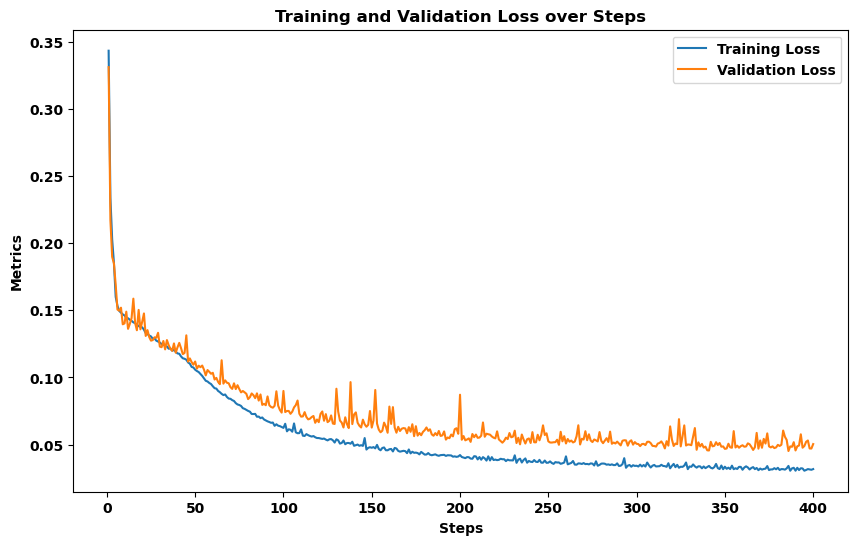

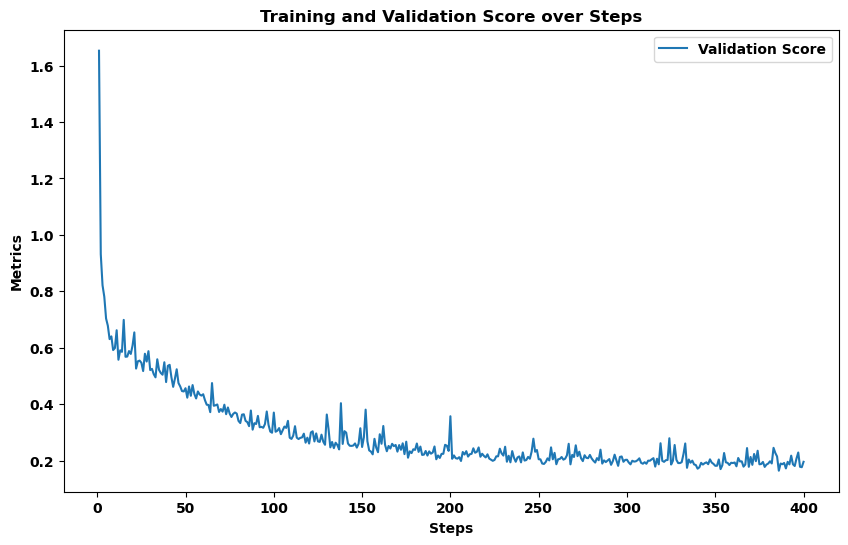

In [9]:
api = wandb.Api()

# Retrieve all runs
runs = api.runs(f"{entity}/{project_name}")

# Sort by end time (stop time) and filter only completed runs
finished_runs = [run for run in runs if run.state == "finished"]

if not finished_runs:
    print("❌ No completed run found!")
else:
    last_run = sorted(finished_runs, key=lambda r: r.created_at, reverse=True)[0]
    print("✔️ Last completed run:", last_run.id)

    run = api.run(f"{entity}/{project_name}/{last_run.id}")

history = run.history()

train_rmse = history["epoch/train-RMSE"]
val_rmse = history["epoch/val-RMSE"]
val_score = history["epoch/val-score"]

steps = range(len(history["_step"].values))

plt.figure(figsize=(10, 6))
plt.plot(steps, train_rmse, label="Training Loss")
plt.plot(steps, val_rmse, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Metrics")
plt.title("Training and Validation Loss over Steps")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(steps, val_score, label="Validation Score")
plt.xlabel("Steps")
plt.ylabel("Metrics")
plt.title("Training and Validation Score over Steps")
plt.legend()
plt.show()

In [44]:
from sklearn.metrics import mean_squared_error

# Modell initialisieren und gespeicherte Gewichte laden
model = ATTModel()
model.load_state_dict(torch.load(os.path.join(save_path, f'{config["model"]}_best.pth')))
model = model.to(device)
model.eval()  # Modell in den Evaluierungsmodus setzen

testset = CMAPSS_Dataset(
    mode = 'test',
    data_path=data_path,
    subset=subset,
    seq_length=seq_length,
    max_rul=max_rul
)
test_loader = DataLoader(dataset=testset, batch_size=1000, shuffle=False, num_workers=0)

all_predictions_24 = []
all_labels_24 = []

# Testdaten auswerten
with torch.no_grad():
    for data in test_loader:
        X, handcrafted_feature, y = data
        X, handcrafted_feature, y = X.to(device), handcrafted_feature.to(device), y.to(device)

        predictions = model(X, handcrafted_feature)

        # Verarbeite die Vorhersagen (z. B. Speichern oder Auswerten)
        pred_batch = predictions.squeeze().detach().cpu().numpy() * max_rul
        labels_batch = y.squeeze().detach().cpu().numpy() * max_rul

        # Sammle alle Vorhersagen und Labels
        all_predictions_24.extend(pred_batch)
        all_labels_24.extend(labels_batch)

# Konvertiere die Listen in NumPy-Arrays
all_predictions_24 = np.array(all_predictions_24)
all_labels_24 = np.array(all_labels_24)

rmse_24 = np.sqrt(mean_squared_error(all_labels_24, all_predictions_24))
print(f'RMSE: {rmse_24:.3f}')

score_24 = Trainer.score(torch.tensor(all_labels_24), torch.tensor(all_predictions_24))
print(f'Score: {score_24:.3f}')

# Save predictions
model_results["ATT_24"] = {
    "predictions": all_predictions_24,
    "labels": all_labels_24,
    "rmse": rmse_24,
    "score": score_24   
}

Found 507 unique motor IDs in the data set.
RMSE: 19.318
Score: 20245.803


In [45]:
import pandas as pd
from sklearn.metrics import f1_score, mean_squared_error

rul_score = Trainer.score

load_path = os.path.join(data_path, 'ids.txt')
arrays = {}
current_key = None

with open(load_path, 'r') as file:
    for line in file:
        line = line.strip()
        if line.startswith("id"):
            current_key = line.replace(":", "")
            arrays[current_key] = []
        elif current_key and line:
            arrays[current_key].extend(map(int, line.split()))

# Konvertieren in NumPy-Arrays
id_train_13 = np.array(arrays["id_train13"])
id_train_24 = np.array(arrays["id_train24"])
id_test_13 = np.array(arrays["id_test13"])
id_test_24 = np.array(arrays["id_test24"])

print("Array1:", id_train_13.shape)
print("Array2:", id_train_24.shape)
print("Array3:", id_test_13.shape)
print("Array4:", id_test_24.shape)


def merge_pred_id(ids, predictions):
    if len(ids) != len(predictions):
        raise ValueError("IDs und Predictions müssen die gleiche Länge haben.")

    combined = np.column_stack((ids, predictions))
    return combined

print(f'Pred13: {len(all_predictions_13)} -- IDs13: {len(id_test_13)}')
print(f'Pred24: {len(all_predictions_24)} -- IDs13: {len(id_test_24)}')

predictions13 = merge_pred_id(id_test_13, all_predictions_13)
predictions24 = merge_pred_id(id_test_24, all_predictions_24)

combined = np.vstack((predictions13, predictions24))
predicted_rul = combined[np.argsort(combined[:, 0])]
rul_true = rul = np.loadtxt(os.path.join(data_path, 'RUL_test.txt'), dtype=np.float32)

rul_true = np.minimum(rul_true, 125)

rmse = np.sqrt(mean_squared_error(rul_true, predicted_rul[:,1]))
print(f'RMSE: {rmse:.1f}')

score = rul_score(torch.tensor(rul_true), torch.tensor(predicted_rul[:,1]))
print(f'RUL-Score: {score:.0f}')

predicted_labels = predicted_rul.copy()
predicted_labels[:,1] = (predicted_rul[:,1] <= 100).astype(int)
true_labels = (rul_true <= 100).astype(int)

F1_score = f1_score(true_labels, predicted_labels[:,1])
print(f'F1 Score: {F1_score:.3f}')

df_result = pd.DataFrame(predicted_labels, columns=['engine_no', 'result'], dtype=int)
display(df_result)
model_name = 'ATT'
# Speichern als CSV-Datei
csv_file_path = os.path.join(result_path, f'results_{model_name}.csv')
df_result.to_csv(csv_file_path, index=False)

# Save predictions
model_results["ATT"] = {
    "predictions": np.array(predicted_rul[:,1]),
    "labels": np.array(rul_true),
    "rmse": rmse,
    "score": score,
    "f1_score": F1_score
}

Array1: (200,)
Array2: (509,)
Array3: (200,)
Array4: (507,)
Pred13: 200 -- IDs13: 200
Pred24: 507 -- IDs13: 507
RMSE: 18.0
RUL-Score: 20997
F1 Score: 0.876


,engine_no,result
0,0,1
1,1,1
2,2,0
3,3,0
4,4,1
...,...,...
702,702,0
703,703,0
704,704,1
705,705,1


In [46]:
file_path = os.path.join(result_path, "ATT_predictions.npz")
np.savez(file_path, model_results=model_results)